In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_pretrained_vit import ViT
from torchvision.transforms import v2

In [2]:
# Define a custom dataset for Fashion MNIST
class FashionMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

In [3]:
# Set up data transforms
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

# Load the Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [4]:
cutmix = v2.CutMix(num_classes=10)
mixup = v2.MixUp(num_classes=10)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

# Initialize the ViT model
model = ViT('B_16', image_size=28, num_classes=10, pretrained=True)

# Adjust the model's first layer to handle single-channel input
model.patch_embed = nn.Conv2d(1, 768, kernel_size=16, stride=16)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Resized positional embeddings from torch.Size([1, 197, 768]) to torch.Size([1, 2, 768])
Loaded pretrained weights.


In [5]:
# Lists to store training and test losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
def train(epoch):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
         # Apply either CutMix or MixUp
        data, target = cutmix_or_mixup(data, target)
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += (predicted == target.argmax(1)).sum().item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item()}")

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100.0 * correct / total
    train_accuracies.append(train_accuracy)
    print(f"Train Epoch: {epoch}, Loss: {running_loss / len(train_loader)}, Accuracy: {train_accuracy}%")

# Testing loop
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total
    test_accuracies.append(accuracy)
    test_losses.append(test_loss)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

# Training the ViT model
for epoch in range(1, 11):  # Train for 10 epochs as an example
    train(epoch)
    test()

Train Epoch: 1 [0/60000] Loss: 2.3025851249694824
Train Epoch: 1 [6400/60000] Loss: 2.0654754638671875
Train Epoch: 1 [12800/60000] Loss: 1.403023362159729
Train Epoch: 1 [19200/60000] Loss: 1.6560858488082886
Train Epoch: 1 [25600/60000] Loss: 1.722894310951233
Train Epoch: 1 [32000/60000] Loss: 1.3643890619277954
Train Epoch: 1 [38400/60000] Loss: 2.0032601356506348
Train Epoch: 1 [44800/60000] Loss: 1.837734580039978
Train Epoch: 1 [51200/60000] Loss: 1.4771409034729004
Train Epoch: 1 [57600/60000] Loss: 0.9552240967750549
Train Epoch: 1, Loss: 1.6743269043563525, Accuracy: 47.75%

Test set: Average loss: 0.9215, Accuracy: 73.57%

Train Epoch: 2 [0/60000] Loss: 1.8235567808151245
Train Epoch: 2 [6400/60000] Loss: 1.0324290990829468
Train Epoch: 2 [12800/60000] Loss: 1.2560796737670898
Train Epoch: 2 [19200/60000] Loss: 1.4190422296524048
Train Epoch: 2 [25600/60000] Loss: 1.6226530075073242
Train Epoch: 2 [32000/60000] Loss: 1.7234736680984497
Train Epoch: 2 [38400/60000] Loss: 1.92

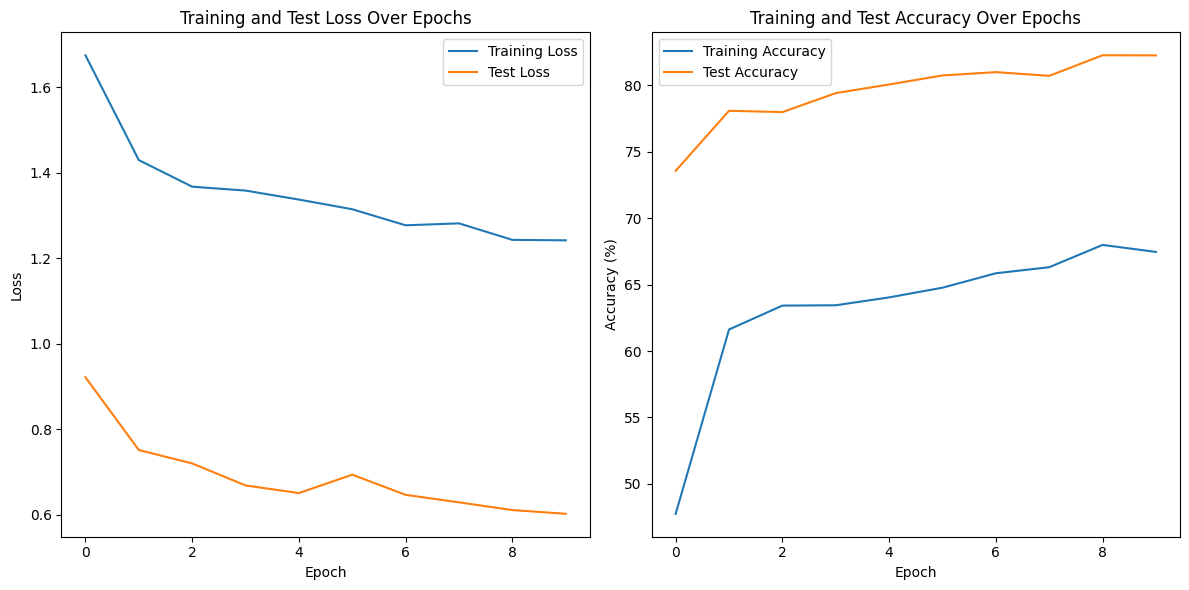

In [6]:
# Plot the training and test losses and accuracies together
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss Over Epochs")

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Test Accuracy Over Epochs")

plt.tight_layout()
plt.show()

In [7]:
print(train_losses)

[1.6743269043563525, 1.4292877216710211, 1.3670350243287808, 1.3579459354313197, 1.3369241496647344, 1.3142888722643415, 1.2767411717600914, 1.2813067927416453, 1.2426917772811612, 1.2415897077334714]


In [8]:
print(test_losses)

[0.9215200968608734, 0.7513292260990021, 0.7199410230490813, 0.6685042907098296, 0.6506355972426712, 0.6935970247930782, 0.6464861101785283, 0.6289460776717799, 0.6109151209995245, 0.6021956266111629]


In [9]:
print(train_accuracies)

[47.75, 61.625, 63.42333333333333, 63.44833333333333, 64.04166666666667, 64.77166666666666, 65.85833333333333, 66.31333333333333, 67.99166666666666, 67.465]


In [10]:
print(test_accuracies)

[73.57, 78.09, 77.99, 79.42, 80.07, 80.75, 81.0, 80.72, 82.27, 82.26]
